In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from glob import glob
import seaborn as sns
from PIL import Image
import keras
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Size default
SIZE = 32

# Loading dataset

In [2]:
# read the training dataset
train = pd.read_csv('data_labels_mainData.csv')

# display the first 5 rows
train.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


Text(0.5, 1.0, 'cellType')

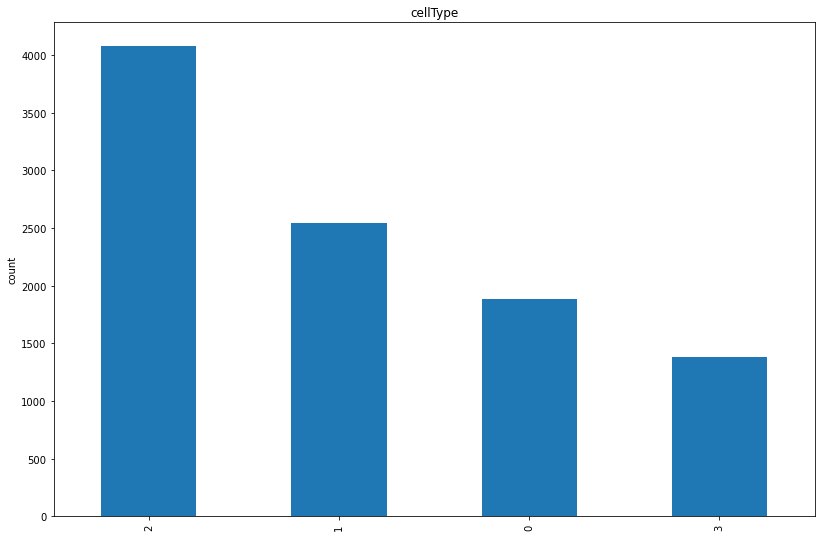

In [3]:
# Plot the datagram represent the number of data of each cellType 
fig = plt.figure(figsize=(30,20))
ax1=fig.add_subplot(221)
train['cellType'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('count')
ax1.set_title('cellType')

In [4]:
# count value of each cellType
train.cellType.value_counts()

2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64

# Data Preparation and Processing

In [5]:
# define new dataframe to store data of each cellType
train_0 = train[train['cellType'] == 0]
train_1 = train[train['cellType'] == 1]
train_2 = train[train['cellType'] == 2]
train_3 = train[train['cellType'] == 3]

In [6]:
# set the number of data of others cellType = number of data of cellType 2 (balance data)
train_0_balanced = resample(train_0, replace=True, n_samples = len(train_2), random_state = 42)
train_1_balanced = resample(train_1, replace=True, n_samples = len(train_2), random_state = 42)
train_3_balanced = resample(train_3, replace=True, n_samples = len(train_2), random_state = 42)


In [7]:
# combine back to a single dataframe
train_balanced = pd.concat([train_0_balanced,train_1_balanced, train_2, train_3_balanced])

In [8]:
# check the distribution: All cellTypes should be balanced 
print(train_balanced['cellType'].value_counts())

3    4079
2    4079
1    4079
0    4079
Name: cellType, dtype: int64


In [9]:
# shape of dataframe
train_balanced.shape

(16316, 6)

In [10]:
# display the first 5 rows of the new dataframe
train_balanced.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
6095,20563,37,20563.png,fibroblast,0,0
7209,19008,45,19008.png,fibroblast,0,0
4375,20207,23,20207.png,fibroblast,0,0
6768,3940,42,3940.png,fibroblast,0,0
6099,20567,37,20567.png,fibroblast,0,0


In [11]:
# drop unused columns
train_balanced = train_balanced.drop(['InstanceID', 'patientID',"cellTypeName","isCancerous"], axis = 1)

In [12]:
# dataframe after dropping column
train_balanced.head()

,ImageName,cellType
6095,20563.png,0
7209,19008.png,0
4375,20207.png,0
6768,3940.png,0
6099,20567.png,0


In [13]:
# read images based on ImageName from CSV file
path = "patch_images/"

# define the path and add as a new column 
train_balanced['path'] = path + train_balanced['ImageName']

# check the dataframe
train_balanced.head()

,ImageName,cellType,path
6095,20563.png,0,patch_images/20563.png
7209,19008.png,0,patch_images/19008.png
4375,20207.png,0,patch_images/20207.png
6768,3940.png,0,patch_images/3940.png
6099,20567.png,0,patch_images/20567.png


In [14]:
# Use the path to read image and convert image into numpy array
train_balanced['image'] = train_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [15]:
# check dataframe
train_balanced.head(1)

,ImageName,cellType,path,image
6095,20563.png,0,patch_images/20563.png,"[[[242, 164, 208], [236, 159, 206], [229, 153,..."


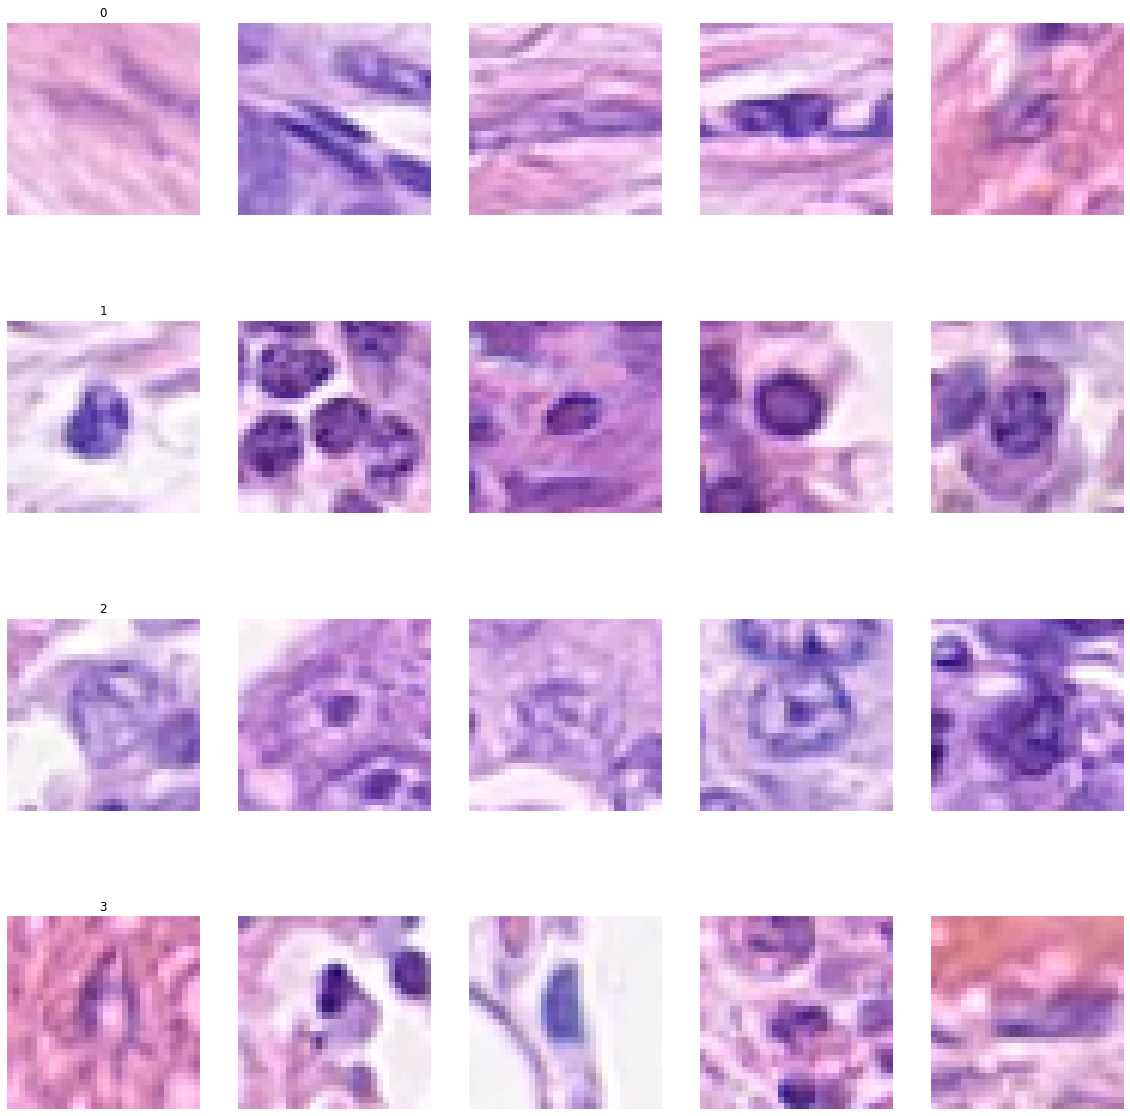

In [16]:
# Plotting some images of each category
fig, m_axs = plt.subplots(4, 5, figsize = (20, 21))
for n_axs, (type_name, type_rows) in zip(m_axs, train_balanced.sort_values(['cellType']).groupby('cellType')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(5, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Extract Training Data using Train_Split_Test

In [17]:
# X is value of images numpy array
X = np.asarray(train_balanced['image'].tolist())

# Scale values to 0:1
X = X/255.

print(X)

[[[[0.94901961 0.64313725 0.81568627]
   [0.9254902  0.62352941 0.80784314]
   [0.89803922 0.6        0.8       ]
   ...
   [0.91372549 0.61568627 0.79215686]
   [0.89411765 0.59607843 0.76470588]
   [0.91372549 0.61568627 0.78431373]]

  [[0.94117647 0.63137255 0.81176471]
   [0.92156863 0.61176471 0.80392157]
   [0.87058824 0.57254902 0.78039216]
   ...
   [0.91372549 0.61568627 0.79215686]
   [0.89019608 0.59607843 0.76470588]
   [0.89019608 0.59215686 0.76078431]]

  [[0.92941176 0.61568627 0.80784314]
   [0.91372549 0.60392157 0.80392157]
   [0.84705882 0.55294118 0.76470588]
   ...
   [0.8627451  0.56470588 0.7372549 ]
   [0.8627451  0.56862745 0.7372549 ]
   [0.86666667 0.56862745 0.7372549 ]]

  ...

  [[0.96078431 0.64313725 0.8       ]
   [0.94117647 0.63137255 0.78431373]
   [0.90196078 0.60784314 0.77254902]
   ...
   [0.83529412 0.54509804 0.74117647]
   [0.85882353 0.57254902 0.75294118]
   [0.92156863 0.65882353 0.82352941]]

  [[0.95294118 0.63921569 0.79607843]
   [0.9

In [18]:
# check the shape of X
X.shape

(16316, 32, 32, 3)

In [19]:
# reshape X
X = X.reshape((4079*4, 32*32*3))

In [20]:
# check the shape of X after reshape
X.shape

(16316, 3072)

In [21]:
# Assign the label values to Y
Y = train_balanced['cellType']

In [24]:
# Split data 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_train shape", y_test.shape)

X_train shape (13052, 3072)
y_train shape (13052,)
X_test shape (3264, 3072)
y_train shape (3264,)


# Build K-nearest neighbors Model and Training model

In [23]:
# Create KNeighbors
knn_cf = KNeighborsClassifier()

# Start training
knn_cf.fit(x_train, y_train)

# Prediction
y_pred = knn_cf.predict(x_test)

# Get Training accuracy score
print("Training Accuracy is :", knn_cf.score(x_train, y_train)*100)

# Get Testing accuracy score
print("Testing Accuracy is :", knn_cf.score(x_test, y_test)*100)
# print out classification report
print(classification_report(y_test, y_pred))

# print confusion matrix
print(confusion_matrix(y_test, y_pred))

Training Accuracy is : 78.33282255593012
Testing Accuracy is : 64.70588235294117
              precision    recall  f1-score   support

           0       0.50      0.89      0.64       808
           1       0.80      0.55      0.65       827
           2       0.72      0.62      0.67       836
           3       0.80      0.52      0.63       793

    accuracy                           0.65      3264
   macro avg       0.70      0.65      0.65      3264
weighted avg       0.70      0.65      0.65      3264

[[723  27  37  21]
 [225 454  88  60]
 [274  20 519  23]
 [234  65  78 416]]
